# Cameron Bronstein 
## Project 3 - Web APIs and Subreddit Classification


In [3]:
import requests
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data Collection via Reddit API

**Setting up urls, headers, and getting initial response back from reddit.**

I used the "climate" and "climate skeptics" subreddits as I thought these would be interesting to compare using natural language processing (and believing that people seeking out climate change related research or journalism are typically a smaller, scientifically educated bunch, while climate change deniers typically have less technical training and are significantly more right leaning in their politics).

In [552]:
url_climate = 'https://www.reddit.com/r/climate.json'            #Making a request directly on the json text 
url_skeptics = 'https://www.reddit.com/r/climateskeptics.json'   #of each subreddit

headers = {'User-agent': 'cameron_b'}                  #I specifiy a 'User-agent' as an ID for reddit's API

res_climate = requests.get(url_climate, headers=headers)
res_skeptic = requests.get(url_skeptics, headers=headers)

**Here, I first made a single request and json object from each subreddit to understand the json formatting. This helped me build the function below and store the information I wanted into a dataframe.**

In [553]:
climate_json = res_climate.json()
skeptic_json = res_skeptic.json()

In [557]:
climate_json['data']['children'][0]['data']['title']            #this will be my 'X' variable

'Green New Deal Has Overwhelming Bipartisan Support, Poll Finds. At Least, For Now. Sixty-four percent of Republicans — including 57 percent of conservative Republicans — back the core tenets of the sweeping proposal.'

In [229]:
climate_json['data']['children'][0]['data']['subreddit']        #this will be my target variable

'climate'

In [558]:
#id of the last post in the list - each request loop will specify a new 'after' ID.
climate_json['data']['after']

't3_a70c1r'

### Function to make Reddit API request and convert all the desired text into a dataframe

In [559]:
def url_to_dataframe(url, header, loop_count, after=None):
    headers = {'User-agent': header}                #In case reddit blocked access to the API,
    posts = []                                      #I could specify a new User-agent each time I run the function

    for i in range(loop_count):                     #Loop-count = number of requests, with 25 posts per loop
        print("Processing Loop number: " + str(i))
        if after == None:                           #Typically, there is no after for the first loop because I
             params = {}                            #start from the first post in the subreddit
        else:
            params = {'after': after}               #other loops will specify a new 'after' - variable below
        new_url = url
        res = requests.get(new_url, params=params, headers=headers)       #request
        if res.status_code == 200: 
            the_json = res.json()                   #getting the json of the web text -a list of dictionaries!
            for i in the_json['data']['children']:  #for each dictionary in list
                text_dict = {}                      #instaniate new dictionary with keys for all the 'columns'
                text_dict['url'] = i['data']['url']
                text_dict['post_title'] = i['data']['title']
                text_dict['subreddit'] = i['data']['subreddit']
                text_dict['ups'] = i['data']['ups']
                text_dict['domain'] = i['data']['domain']
                text_dict['downs'] = i['data']['downs']
                text_dict['score'] = i['data']['score']
                text_dict['num_comments'] = i['data']['num_comments']
 
                posts.append(text_dict)         #creating a list of dictionaries, all with the same keys(columns)
                                                #each dictionary is a row in the dataframe
            after = the_json['data']['after']
            print(after)
        
        else:
            print(res.status_code)
            break
        
        time.sleep(2)
    
            
    return pd.DataFrame(posts)                  #convert list of dictionaries to dataframe.

### Calling the function on each subreddit and getting all of my data.

In [560]:
climate = url_to_dataframe(url_climate,
                               header = 'goodmorning',
                               loop_count=40, after='t3_a1tksv')

In [561]:
skeptic = url_to_dataframe(url_skeptics, 
                              header = 'deeedumdeeedlydooahh', 
                              loop_count=40, after= 't3_a1vb41')

### Some cleanup to remove duplicates... 

**Initially I tried to run the requests function multiple times to get more than 1000 posts per subreddit. However, I was limited to 1000 unique posts by the API - which continued to pull the same posts over and over.**

In [285]:
#appending of multiple dataframes resulted in duplicate posts and duplicate index values
climate.reset_index(drop=True, inplace=True)

In [309]:
#dropping duplicates!
climate.drop_duplicates(keep='first', inplace=True)

In [317]:
climate['post_title'].drop_duplicates(inplace=True)

In [324]:
climate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 2492
Data columns (total 9 columns):
domain              1541 non-null object
downs               1541 non-null int64
mod_reason_title    0 non-null object
num_comments        1541 non-null int64
post_title          1541 non-null object
score               1541 non-null int64
subreddit           1541 non-null object
ups                 1541 non-null int64
url                 1541 non-null object
dtypes: int64(4), object(5)
memory usage: 116.0+ KB


## Combining dataframes into a final Skeptic Subreddit DF 
_This was the result of multiple API requests_

In [232]:
skeptic = skeptic_df.append(skeptic_df_2)

In [234]:
skeptic.shape

(2219, 10)

In [315]:
skeptic['post_title'].drop_duplicates().shape

(1001,)

In [326]:
skeptic.drop('media', axis=1, inplace=True)

### Combining climate and climate_skeptics subreddits into on dataframe

In [327]:
df = climate.append(skeptic)

In [337]:
#dropping this because it was almost completely null for all the reddit posts I pulled.
df.drop('mod_reason_title', axis=1, inplace=True)

In [340]:
#resetting index as combining dataframes resulted in duplicated indices.
df.reset_index(inplace=True)

**Dropping all duplicate posts, based on the post title**

In [345]:
#df['post_title'].value_counts(ascending=False) easily showed if there were any duplicate posts
df.drop_duplicates(subset='post_title', keep='first', inplace=True)

In [348]:
df.subreddit.value_counts()

climateskeptics    990
climate            979
Name: subreddit, dtype: int64

In [361]:
df.drop(columns='index', inplace=True)

In [365]:
df.columns

Index(['domain', 'downs', 'num_comments', 'post_title', 'score', 'subreddit',
       'ups', 'url'],
      dtype='object')

In [381]:
df.head()

,domain,downs,num_comments,post_title,score,subreddit,ups,url
0,nytimes.com,0,5,John Kerry: Forget Trump. We All Must Act on C...,89,climate,89,https://www.nytimes.com/2018/12/13/opinion/ker...
1,i.redd.it,0,3,The scientific consensus on climate change is ...,53,climate,53,https://i.redd.it/x0gmjelle6421.jpg
2,bbc.com,0,6,Climate change: Failure to tackle warming 'sui...,194,climate,194,https://www.bbc.com/news/science-environment-4...
3,indianexpress.com,0,1,Indian Ocean may play bigger role in driving c...,8,climate,8,https://indianexpress.com/article/technology/s...
4,cbsnews.com,0,0,Tariffs cast a shadow on U.S. solar industry,9,climate,9,https://www.cbsnews.com/news/us-solar-industry...


In [382]:
df.downs.value_counts()

0    1985
Name: downs, dtype: int64

In [563]:
#These columns did not have particularly useful information
df.drop(columns=['downs', 'ups'], inplace=True)

In [391]:
#again resetting the index after combining dataframes
df.reset_index(inplace=True)

In [393]:
df.drop(columns='index', inplace=True)

In [396]:
#changing column names
df.columns = ['domain', 'comments', 'title', 'score', 'subreddit', 'url']

## Saving dataframe to a csv - careful not to rewrite!

In [8]:
#df.to_csv('./data/project_3_subreddit_data', index=False)

## Load in CSV

In [1]:
df = pd.read_csv('./data/project_3_subreddit_data')

NameError: name 'pd' is not defined

In [2]:
df.head()

NameError: name 'df' is not defined

In [131]:
df['title'][1]                #exactly the data I want!

'The scientific consensus on climate change is very clear, and yet some people are still like…'

In [859]:
df.dtypes

domain                 object
comments                int64
title                  object
score                   int64
subreddit               int64
url                    object
lemmatized             object
stemmed                object
avg_word_len          float64
title_length            int64
lemmatized             object
positive_sentiment    float64
negative_sentiment    float64
neutral_sentiment     float64
compound_sentiment    float64
dtype: object

## Text Preprocessing

In [782]:
#first = words/ character groups followed by not space (up until space)
#while I didn't exactly use this, the function below allows for separating all the text different depending
#on the regular expression used in the function.
regular_expressions = ['\w+[^ ]', '[A-Z]\w+', "\w+[']*[a-z]*", "\w+['.-]*[0-9A-Za-z]+[.]*", 
                       '\s+(, gaps=True)']


In [615]:
def preprocessed_columns(dataframe = df, 
                        column = 'title', 
                        new_lemma_column = 'lemmatized', 
                        new_stem_column = 'stemmed',
                        new_avg_len_column = 'avg_word_len',
                        regular_expression = r'\w+'): 
    
    tokenizer = RegexpTokenizer(regular_expression)      #Instantiate tokenizer with specific regular expression
    lemmatizer = WordNetLemmatizer()                     #Instantiate lemmatizer
    stemmer = PorterStemmer()                            #Instantiate stemmer
    
    lemmatized = []                                      #list to append lemmatized data
    stemmed = []                                         #list to append stemmed words
    
    sid = SentimentIntensityAnalyzer()                   #Instantiating Sentiment Intensity Analyzer
    negative_list = []                                   #These lists will be appended below with the analyzer's
    positive_list = []                                   #sentiment calculations for each post title and then used
    neutral_list = []                                    #to create new columns/variables in the dataframe
    compound_list = []
    
    for i in dataframe[column]:                          #Iterate through all the rows in specific column

        tokens = tokenizer.tokenize(i.lower())           #Converting string titles to tokens 

        lemma = [lemmatizer.lemmatize(token) for token in tokens]     #lemmatizing all tokens
        lemmatized.append(lemma)                                      #appending lemma to lemmatized list

        stems = [stemmer.stem(token) for token in tokens]             #stemming all tokens
        stemmed.append(stems)                                         #creating stem list
     
        #Sentiment analysis - this creates columns with information on negative, positive, neutral
        #and compound (i.e. overall) sentiment.

        ss = sid.polarity_scores(i)
        negative_list.append(ss['neg'])
        neutral_list.append(ss['neu'])
        positive_list.append(ss['pos'])
        compound_list.append(ss['compound'])

    avg_len_list = []                                       
    title_length_list = []
    for title in lemmatized:                
        title_length = 0                   
        count = 0
        for word in title:
            title_length += 1                   #Creating a feature for number of words per post
            count += len(word)                  #Creating a feature for average word length for each post

        avg_len = (count/len(title))
        avg_len_list.append(avg_len)
        title_length_list.append(title_length)
        
    dataframe[new_lemma_column] = [' '.join(i) for i in lemmatized]   #rejoing the lists for each title
    dataframe[new_stem_column] = [' '.join(i) for i in stemmed]       #setting results to be new columns in df   
    
    dataframe[new_avg_len_column] = avg_len_list
    dataframe['title_length'] = title_length_list
    
    dataframe['positive_sentiment'] = positive_list
    dataframe['negative_sentiment'] = negative_list
    dataframe['neutral_sentiment'] = neutral_list
    dataframe['compound_sentiment'] = compound_list

**_Calling the function to preprocess the text and create some numeric features_**

In [616]:
preprocessed_columns(dataframe=df, column='title', regular_expression=r'\w+', new_lemma_column='lemmatized', 
                    new_stem_column='stemmed', new_avg_len_column= 'avg_word_len')

In [617]:
df.head()

,domain,comments,title,score,subreddit,url,lemmatized,stemmed,avg_word_len,title_length,lemmatized,positive_sentiment,negative_sentiment,neutral_sentiment,compound_sentiment
0,nytimes.com,5,John Kerry: Forget Trump. We All Must Act on C...,89,0,https://www.nytimes.com/2018/12/13/opinion/ker...,john kerry forget trump we all must act on cli...,john kerri forget trump we all must act on cli...,4.272727,11,john kerry forget trump we all must act on cli...,0.000,0.160,0.840,-0.2263
1,i.redd.it,3,The scientific consensus on climate change is ...,53,0,https://i.redd.it/x0gmjelle6421.jpg,the scientific consensus on climate change is ...,the scientif consensu on climat chang is veri ...,4.750000,16,the scientific consensus on climate change is ...,0.162,0.000,0.838,0.4391
2,bbc.com,6,Climate change: Failure to tackle warming 'sui...,194,0,https://www.bbc.com/news/science-environment-4...,climate change failure to tackle warming suici...,climat chang failur to tackl warm suicid the u...,5.083333,36,climate change failure to tackle warming suici...,0.107,0.276,0.617,-0.8559
3,indianexpress.com,1,Indian Ocean may play bigger role in driving c...,8,0,https://indianexpress.com/article/technology/s...,indian ocean may play bigger role in driving c...,indian ocean may play bigger role in drive cli...,5.000000,10,indian ocean may play bigger role in driving c...,0.211,0.000,0.789,0.3400
4,cbsnews.com,0,Tariffs cast a shadow on U.S. solar industry,9,0,https://www.cbsnews.com/news/us-solar-industry...,tariff cast a shadow on u s solar industry,tariff cast a shadow on u s solar industri,3.777778,9,tariff cast a shadow on u s solar industry,0.000,0.000,1.000,0.0000


## Some EDA

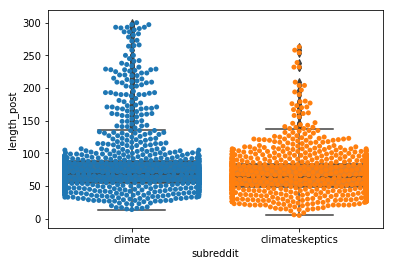

In [88]:
ax = sns.boxplot(x=df['subreddit'], y=df['length_post'])
ax = sns.swarmplot(x=df['subreddit'], y=df['length_post'])

In [150]:
df['subreddit'].value_counts()

climate            994
climateskeptics    991
Name: subreddit, dtype: int64

<BarContainer object of 1985 artists>

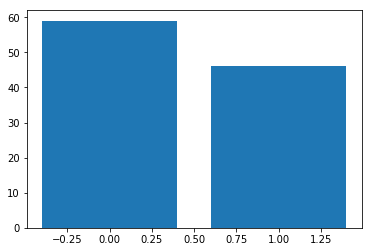

In [797]:
plt.bar(x=df['subreddit'], height=df['title_length'])

In [872]:
df.corr()['subreddit'].sort_values(ascending=False)

subreddit             1.000000
comments              0.204698
negative_sentiment    0.110934
avg_word_len          0.016260
positive_sentiment   -0.050364
neutral_sentiment    -0.056250
score                -0.071983
compound_sentiment   -0.090405
title_length         -0.149237
Name: subreddit, dtype: float64

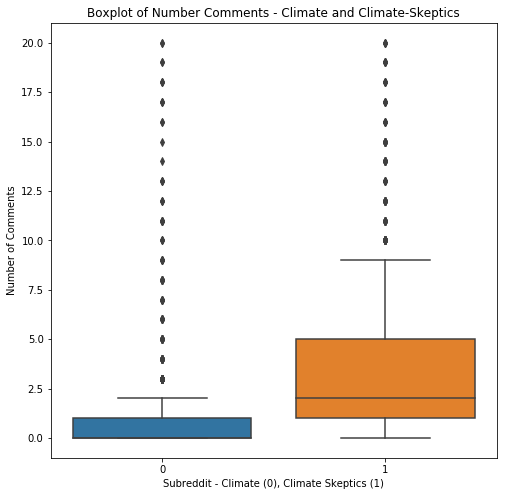

In [900]:
plt.figure(figsize=(8,8))
plt.title("Boxplot of Number Comments - Climate and Climate-Skeptics")
ax = sns.boxplot(x=df['subreddit'], y=df[df['comments'] <= 20]['comments'], whis=1)
ax.set_xlabel("Subreddit - Climate (0), Climate Skeptics (1)")
ax.set_ylabel("Number of Comments");

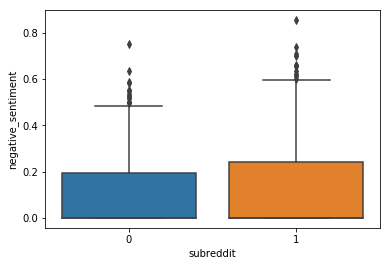

In [874]:
sns.boxplot(x=df['subreddit'], y=df['negative_sentiment'], )

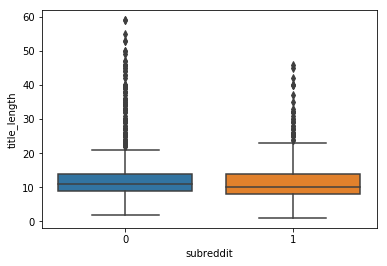

In [875]:
sns.boxplot(x=df['subreddit'], y=df['title_length'])

## Changing the values of Climate and Climate Skeptics to Binary

In [151]:
df['subreddit'] = df['subreddit'].replace(['climate', 'climateskeptics'], [0, 1])

In [564]:
# Climate = 0, Skeptics = 1
df['subreddit'].value_counts()

0    994
1    991
Name: subreddit, dtype: int64

# MODELING

### BASELINE PREDICTION:  50.08 %

In [156]:
df.subreddit.value_counts(normalize=True)

0    0.500756
1    0.499244
Name: subreddit, dtype: float64

####  This function will be used repeatedly for all the iterations of vectorizer and model testing 

In [590]:
def text_to_model(X_column, model, vectorizer, params):
    
    X = df[X_column]                                    #creates X and y
    y = df['subreddit']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)    #train test split
    
    pipe = Pipeline([                               #pipeline to run with gridsearch and test hyperparameters
        ('vectorizer', vectorizer),                 #for both the model and vectorizer.
        ('model', model)])                          #this will be done for many vectorizer-model combinations
        
    grid = GridSearchCV(pipe, param_grid=params, cv=5, verbose=1)  
    
    grid.fit(X_train, y_train)                       #fitting the grid model to X_train and y_train and 
                                                     #running a 5 fold cross validation
    score_dict = {}
    
    score_dict['X'] = X_column                               #this dict will be converted to dataframe to store 
    score_dict['Vectorizer'] = vectorizer                    #the performance of each gridsearch and return the 
    score_dict['Model'] = model                              #best parameters and score to compare to other models
    score_dict['train_score'] = grid.score(X_train, y_train)
    score_dict['test_score'] = grid.score(X_test, y_test)
    score_dict['best_params'] = grid.best_params_
    
    try:
        return pd.DataFrame(score_dict)
    except:
        return score_dict

### KNearestNeighbors and Count Vectorizer
#### Accuracy = 0.637

In [533]:
knn = KNeighborsClassifier()
cv = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__n_neighbors':[1, 5, 10, 20, 50],
          'model__p':[1,2]
         }

count_vect_knn = text_to_model(X_column='title', model = knn, vectorizer=cv, params=params)
count_vect_knn

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   27.7s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__n_neighbors,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,1
model__p,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,1
vectorizer__max_df,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,1
vectorizer__max_features,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,4000
vectorizer__min_df,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,1
vectorizer__ngram_range,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,"(1, 1)"
vectorizer__stop_words,title,"CountVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.637827,english


### KNearestNeighbors and TF-IDF Vectorizer
#### Accuracy = 0.646

In [535]:
knn = KNeighborsClassifier()
tfidf = TfidfVectorizer()

params = {'vectorizer__stop_words': ['english', None],
          'vectorizer__max_features':[4000, None],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__n_neighbors':[1, 5],
          'model__p':[1]
         }

tfidf_knn = text_to_model(X_column='title', model = knn, vectorizer=tfidf, params=params)
tfidf_knn

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   46.9s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__n_neighbors,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,1
model__p,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,1
vectorizer__max_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,1
vectorizer__max_features,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,4000
vectorizer__min_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,1
vectorizer__ngram_range,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,"(1, 1)"
vectorizer__stop_words,title,"TfidfVectorizer(analyzer='word', binary=False,...","KNeighborsClassifier(algorithm='auto', leaf_si...",1.0,0.645875,english


### Testing Multinomial Naive Bayes Model with TF-IDF Vectorizer
#### Accuracy = 0.73

In [550]:
bayes = MultinomialNB()
tfidf = TfidfVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[0.4]
         }
tfidf_NB = text_to_model(X_column='title', model = bayes, vectorizer=tfidf, params=params)
tfidf_NB

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


,X,Vectorizer,Model,train_score,test_score,best_params
vectorizer__max_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.956989,0.730382,0.4
vectorizer__max_features,title,"TfidfVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.956989,0.730382,4000
vectorizer__min_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.956989,0.730382,1
vectorizer__ngram_range,title,"TfidfVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.956989,0.730382,"(1, 1)"
vectorizer__stop_words,title,"TfidfVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.956989,0.730382,english


### Naive Bayes and CountVectorizer
#### Accuracy = 0.728

In [520]:
bayes = MultinomialNB()
count_vect = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[None],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'vectorizer__binary':[False]
         }
cv_NB = text_to_model(X_column='title', model = bayes, vectorizer=count_vect, params=params)
cv_NB

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


,X,Vectorizer,Model,train_score,test_score,best_params
vectorizer__binary,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,False
vectorizer__max_df,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,1
vectorizer__max_features,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,None
vectorizer__min_df,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,1
vectorizer__ngram_range,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,"(1, 1)"
vectorizer__stop_words,title,"CountVectorizer(analyzer='word', binary=False,...","MultinomialNB(alpha=1.0, class_prior=None, fit...",0.949597,0.72837,english


### TF-IDF and Logistic Regression
#### Accuracy = 0.742

In [527]:
logreg = LogisticRegression()
tfidf = TfidfVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[0.4],
          'model__penalty':['l1', 'l2']
         }
tfidf_LogReg = text_to_model(X_column='title', model = logreg, vectorizer=tfidf, params=params)
tfidf_LogReg

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__penalty,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,l2
vectorizer__max_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,0.4
vectorizer__max_features,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,4000
vectorizer__min_df,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,1
vectorizer__ngram_range,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,"(1, 1)"
vectorizer__stop_words,title,"TfidfVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.942876,0.742455,english


### CountVectorizer and Logistic Regression
#### Accuracy = 0.746

In [532]:
logreg = LogisticRegression()
cv = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__penalty':['l2']
         }
count_vect_LogReg = text_to_model(X_column='title', model = logreg, vectorizer=cv, params=params)
count_vect_LogReg

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__penalty,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,l2
vectorizer__max_df,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,1
vectorizer__max_features,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,4000
vectorizer__min_df,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,1
vectorizer__ngram_range,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,"(1, 1)"
vectorizer__stop_words,title,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.976478,0.746479,english


### Logistic Regression on Stemmed version of Post Title 
#### Accuracy = 0.740
##### Stemming seems to be overkill and does not improve predictions over lemmatizing

In [565]:
logreg = LogisticRegression()
cv = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__penalty':['l2']
         }
count_vect_LogReg = text_to_model(X_column='stemmed', model = logreg, vectorizer=cv, params=params)
count_vect_LogReg

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__penalty,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,l2
vectorizer__max_df,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,1
vectorizer__max_features,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,4000
vectorizer__min_df,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,1
vectorizer__ngram_range,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,"(1, 1)"
vectorizer__stop_words,stemmed,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.97043,0.740443,english


# Setting up X with Lemmatized Post Title 

- This proves to be the best preprocessed text to vectorize.

### Logistic Regression on Lemmatized Text
#### Accuracy = 0.755 (best yet!)

In [798]:
logreg = LogisticRegression()
cv = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__penalty':['l2'],
          'model__C':[0.001, 0.05, 0.1, 0.5, 1.0, 5.0, 10]
         }
count_vect_LogReg = text_to_model(X_column='lemmatized', model = logreg, vectorizer=cv, params=params)
count_vect_LogReg

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.3s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__C,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,1
model__penalty,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,l2
vectorizer__max_df,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,1
vectorizer__max_features,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,4000
vectorizer__min_df,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,1
vectorizer__ngram_range,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,"(1, 1)"
vectorizer__stop_words,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","LogisticRegression(C=1.0, class_weight=None, d...",0.973118,0.754527,english


### A Single Decision Tree was not the ideal model, even with hyperparameter tuning
#### Accuracy = 0.666

In [591]:
tree = DecisionTreeClassifier()
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[10000, 8000, 12000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__criterion':['entropy'],
          'model__max_features':[0.9],
          'model__max_depth':[None]
         }
count_vect_tree = text_to_model(X_column='lemmatized', model = tree, vectorizer = count, params=params)
count_vect_tree

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.3s finished


,X,Vectorizer,Model,train_score,test_score,best_params
model__criterion,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,entropy
model__max_depth,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,None
model__max_features,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,0.9
vectorizer__max_df,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,1
vectorizer__max_features,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,8000
vectorizer__min_df,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,1
vectorizer__ngram_range,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,"(1, 1)"
vectorizer__stop_words,lemmatized,"CountVectorizer(analyzer='word', binary=False,...","DecisionTreeClassifier(class_weight=None, crit...",1.0,0.665996,english


### Count Vectorizer and RandomForest
#### Accuracy = 0.724

In [592]:
forest = RandomForestClassifier(n_estimators=10)
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__criterion':['entropy'],
          'model__max_features':['auto'],
          'model__max_depth':[None, 100]
         }

count_vect_forest = text_to_model(X_column='lemmatized', model = forest, vectorizer = count, params=params)
count_vect_forest

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


{'X': 'lemmatized',
 'Vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'Model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'train_score': 0.9758064516129032,
 'test_score': 0.7243460764587525,
 'best_params': {'model__criterion': 'entropy',
  'model__max_depth': No

### TF - IDF and Random Forest Classifier
#### Accuracy = 0.69

In [621]:
forest = RandomForestClassifier(n_estimators=10)
tfidf = TfidfVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[1000, 2000, 500],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__criterion':['gini'],
          'model__max_features':['auto'],
          'model__max_depth':[25, 75, 50]
         }

tfidf_vect_forest = text_to_model(X_column='lemmatized', model = forest, vectorizer = tfidf, params=params)
tfidf_vect_forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    2.6s finished


{'X': 'lemmatized',
 'Vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
         stop_words=None, strip_accents=None, sublinear_tf=False,
         token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
         vocabulary=None),
 'Model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'train_score': 0.9307795698924731,
 'test_score': 0.6921529175050302,

### Count Vectorizer and ExtraTrees
#### Accuracy = 0.700

In [622]:
extra = ExtraTreesClassifier()
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english', None],
          'vectorizer__max_features':[2000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__criterion':['gini'],
          'model__max_features':['auto'],
          'model__max_depth':[25]
         }

count_vect_extra = text_to_model(X_column='lemmatized', model = extra, vectorizer = count, params=params)
count_vect_extra

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:   30.3s finished


{'X': 'lemmatized',
 'Vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'Model': ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 'train_score': 0.8608870967741935,
 'test_score': 0.7002012072434608,
 'best_params': {'model__criterion': 'gini',
  'model__max_depth': 25,
  'model__max_fe

### Bagging! with DecisionTreeClassifier
#### Accuracy = 0.767

In [720]:
bag = BaggingClassifier()
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__max_samples':[1.0],
          'model__n_estimators':[100],
          'model__bootstrap':[False],
          'model__bootstrap_features':[True],
          'model__max_features':[0.5]
         }

count_vect_bag = text_to_model(X_column='lemmatized', model = bag, vectorizer = count, params=params)
count_vect_bag

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.4s finished


{'X': 'lemmatized',
 'Vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'Model': BaggingClassifier(base_estimator=None, bootstrap=True,
          bootstrap_features=False, max_features=1.0, max_samples=1.0,
          n_estimators=10, n_jobs=None, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
 'train_score': 1.0,
 'test_score': 0.7665995975855131,
 'best_params': {'model__bootstrap': False,
  'model__bootstrap_features': True,
  'model__max_features': 0.5,
  'model__max_samples': 1.0,
  'model__n_estimators': 100,
  'vectorizer__max_df': 1.0,
  'vectorizer__max_features': 4000,
  'vectorizer__min_df': 1,
  'vectorizer_

### Bagging with Logistic Regression
#### Accuracy = 0.757

In [721]:
bag = BaggingClassifier(base_estimator=LogisticRegression())
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__max_samples':[0.75],
          'model__n_estimators':[200],
          'model__bootstrap':[True],
          'model__bootstrap_features':[True],
          'model__max_features':[1.0]
         }

count_vect_bag_logreg = text_to_model(X_column='lemmatized', model = bag, vectorizer = count, params=params)
count_vect_bag_logreg

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    5.9s finished


{'X': 'lemmatized',
 'Vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'Model': BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False,
          random_state=None, verbose=0, warm_start=False),
 'train_score': 0.9428763440860215,
 'test_score': 0.7565392354124748,

## Boosting with Logistic Regression
#### Accuracy = 0.728

In [647]:
boost = AdaBoostClassifier()
count = CountVectorizer()

params = {'vectorizer__stop_words': ['english'],
          'vectorizer__max_features':[4000],
          'vectorizer__ngram_range':[(1,1)],
          'vectorizer__min_df':[1],
          'vectorizer__max_df':[1.0],
          'model__n_estimators':[100, 200],
          'model__base_estimator':[LogisticRegression(penalty='l2', C=1)]}

count_vect_boost = text_to_model(X_column='lemmatized', model = boost, vectorizer = count, params=params)
count_vect_boost

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


{'X': 'lemmatized',
 'Vectorizer': CountVectorizer(analyzer='word', binary=False, decode_error='strict',
         dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
         lowercase=True, max_df=1.0, max_features=None, min_df=1,
         ngram_range=(1, 1), preprocessor=None, stop_words=None,
         strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
         tokenizer=None, vocabulary=None),
 'Model': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
 'train_score': 0.8676075268817204,
 'test_score': 0.7283702213279678,
 'best_params': {'model__base_estimator': LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='warn',
            n_jobs=None, penalty='l2', random_state=None, solver='warn',
            tol=0.0001, verbose=0, warm_start=False),
  'model__n_estimators': 200,
  'vectorizer__max_df': 1.0,
  've

# Final Model Comparison 
### Logistic Regression
#### Hyperparameters: 
- **C = 0.5**

### Bagged Logistic Regression
#### Hyperparameters:
- **max_samples = 1.0**
- **n_estimators = 50**
- **max_features = 1.0**

### Bagged Decision Tree Classifier
#### Hyperparameters:
- **n_estimators = 100** 
- **bootstrap = True**
- **bootstrap_features = False**
- **max_features = 0.75**
- **max_samples = 1.0**

### First, setting up X and y to pass through Count Vectorizer.

In [648]:
X = df['lemmatized']
y = df['subreddit']

In [649]:
count_vect = CountVectorizer(max_features=4000, stop_words='english')

X_vect = count_vect.fit_transform(X)

In [666]:
X_vect_df = pd.DataFrame(X_vect.toarray(), columns = count_vect.get_feature_names())

#### Adding Non-vectorized features from the dataframe

In [667]:
X_vect_df['comments'] = df['comments']
X_vect_df['score'] = df['score']
X_vect_df['avg_word_len'] = df['avg_word_len']
X_vect_df['title_length'] = df['title_length']
X_vect_df['positive_sentiment'] = df['positive_sentiment']
X_vect_df['negative_sentiment'] = df['negative_sentiment']
X_vect_df['neutral_sentiment'] = df['neutral_sentiment']
X_vect_df['compound_sentiment'] = df['compound_sentiment']

### Train-Test Split

In [668]:
X_train, X_test, y_train, y_test = train_test_split(X_vect_df, y, stratify=y, random_state=42)

### Logistic Regression
#### Accuracy = 0.759 (no noticeable improvement despite new feature inclusion.**

In [670]:
logreg = LogisticRegression()

params = {'penalty':['l2', 'l1'],
          'C':[0.001, 0.1, 0.5, 1.0, 2.0, 10]}
grid = GridSearchCV(logreg, param_grid=params, cv=5)

grid.fit(X_train, y_train)
print(grid.score(X_train, y_train))
print(grid.score(X_test, y_test))
print(grid.best_params_)
print(grid.best_score_)

0.9509408602150538
0.7585513078470825
{'C': 0.5, 'penalty': 'l2'}
0.7526881720430108


### Logistic Regression Bag Classifier
#### Accuracy = 0.754 (again, no improvement)

In [689]:
logreg_bag = BaggingClassifier(base_estimator=LogisticRegression(C=0.5))

params = {'max_samples':[1.0],
          'n_estimators':[50],
          'max_features':[1.0]
         }

logbag_grid = GridSearchCV(logreg_bag, param_grid=params, cv=5, verbose=2)

logbag_grid.fit(X_train, y_train)

print(logbag_grid.best_score_)
print(logbag_grid.best_params_)
print(logbag_grid.score(X_train, y_train))
print(logbag_grid.score(X_test, y_test))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_features=1.0, max_samples=1.0, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=1.0, max_samples=1.0, n_estimators=50, total=   2.7s
[CV] max_features=1.0, max_samples=1.0, n_estimators=50 ..............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.3s remaining:    0.0s


[CV]  max_features=1.0, max_samples=1.0, n_estimators=50, total=   2.6s
[CV] max_features=1.0, max_samples=1.0, n_estimators=50 ..............
[CV]  max_features=1.0, max_samples=1.0, n_estimators=50, total=   2.7s
[CV] max_features=1.0, max_samples=1.0, n_estimators=50 ..............
[CV]  max_features=1.0, max_samples=1.0, n_estimators=50, total=   2.7s
[CV] max_features=1.0, max_samples=1.0, n_estimators=50 ..............
[CV]  max_features=1.0, max_samples=1.0, n_estimators=50, total=   2.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   16.5s finished


0.7479838709677419
{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
0.9193548387096774
0.7545271629778671


## Decision Tree Bag Classifier
#### Accuracy = 0.823

In [709]:
bag_grid = BaggingClassifier()

params = {'max_samples':[1.0],
          'n_estimators':[100],
          'max_features':[0.75, 0.5, 1.0],
          'bootstrap':[True],
          'bootstrap_features':[False]
         }

treebag_grid = GridSearchCV(bag_grid, param_grid=params, cv=3, verbose=1)

treebag_grid.fit(X_train, y_train)

print(treebag_grid.best_score_)
print(treebag_grid.best_params_)
print(treebag_grid.score(X_train, y_train))
print(treebag_grid.score(X_test, y_test))

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   52.1s finished


0.8279569892473119
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 100}
1.0
0.8229376257545271


### Another iteration of the Bagging Tree Classifier
#### Accuracy = 0.829

In [736]:
tree_bag = BaggingClassifier(n_estimators=100, 
                             bootstrap=True,
                             bootstrap_features=False,
                             max_features = 0.75,
                             max_samples = 1.0)

tree_bag.fit(X_train, y_train)

print(tree_bag.score(X_train, y_train))
print(tree_bag.score(X_test, y_test))

1.0
0.8289738430583501


## Running multiple iterations and taking an average score and Standard Deviation
### Decision Trees are schocastic models, so different iterations will have slight differences.

In [725]:
score_list = []
for i in range(20):
    tree_bag_test = BaggingClassifier(n_estimators=100, 
                             bootstrap=True,
                             bootstrap_features=False,
                             max_features = 0.75,
                             max_samples = 1.0)
    
    tree_bag_test.fit(X_train, y_train)
    score_list.append(tree_bag_test.score(X_test, y_test))

print("""Our model performs with an average accuracy of {} after 20 iterations, 
          and a standard deviation of {}.""".format(np.mean(score_list), np.std(score_list)))



Our model performs with an average accuracy of 0.8202213279678068 after 20 iterations, 
          and a standard deviation of 0.00671185263747321.


### Making predictions on our holdout test data

In [737]:
predictions = tree_bag.predict(X_test)

# Evaluating the Model

In [738]:
cm = confusion_matrix(y_test, predictions)
cm

array([[202,  47],
       [ 38, 210]])

## The model correctly predicted: 
- **202 posts from the Climate Subreddit.**
- **210 posts from the Climate Skeptics Subreddit.**

### The model incorrectly predicted 
- **38 posts from the Climate Skeptics as from the Climate subreddit**
- **47 posts from the Climate forum as from the Climate Skeptics subreddit**

In [740]:
cm_df = pd.DataFrame(data=cm, 
                     index=['Actual Negatives', 'Actual Positives'], 
                     columns=['Predicted Negatives', 'Predicted Positives'])
cm_df

,Predicted Negatives,Predicted Positives
Actual Negatives,202,47
Actual Positives,38,210


In [741]:
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8289738430583501

In [773]:
# true_positives = cm_df.iloc[[1],[1]].items
# true_negatives = cm_df.iloc[[0],[0]].items
# false_positives = cm_df.iloc[[0],[1]].items
# false_negatives = cm_df.iloc[[1],[0]].items

true_positives = cm_df.iat[1,1]
true_negatives = cm_df.iat[0,0]
false_positives = cm_df.iat[0,1]
false_negatives = cm_df.iat[1,0]


In [774]:
#sensitivity - how well the model does at truly predicting a post is from the climate skeptics subreddit
sensitivity = true_positives / (true_positives + false_negatives)
sensitivity

0.8467741935483871

In [777]:
#specificity - how well the model does at truly predicting a post is from the climate subreddit
specificity = true_negatives / (true_negatives + false_positives)
specificity

0.8112449799196787

In [776]:
misclassification = 1 - accuracy
misclassification

0.1710261569416499

### Finding the index for all incorrectly classified reddit posts

In [831]:
y_test_df = pd.DataFrame(data=y_test)

In [833]:
y_test_df['predictions'] = predictions

_DataFrame slice with only the misclassified posts._

In [837]:
misclassified = y_test_df[y_test_df['subreddit'] != y_test_df['predictions']]

_Pulling the indices from misclassified as lists of posts from each subreddit._

In [844]:
#the lengths match our confusion matrix false predictions.
misclassified_skeptic_rows = list(misclassified[misclassified['subreddit'] == 1].index)
len(misclassified_skeptic_rows)

38

In [902]:
misclassified_climate_rows = list(misclassified[misclassified['subreddit'] == 0].index)
len(misclassified_climate_rows)

47

In [907]:
np.random.choice(misclassified_climate_rows, 3)

array([768, 891,  99])

In [905]:
np.random.choice(misclassified_skeptic_rows, 3)

array([1297, 1703, 1047])

In [913]:
df.iloc[[781, 891, 99, 1297, 1703, 1047]][['title', 'domain', 'subreddit']]

,title,domain,subreddit
781,Controversial spraying method aims to curb glo...,cbsnews.com,0
891,Why Is a Climate Change Skeptic Headlining Sci...,thedailybeast.com,0
99,Societies are too divided to combat climate ch...,consciousnessofsheep.co.uk,0
1297,Labor’s solar battery cash splash to cut power...,thewest.com.au,1
1703,How seriously do we take Climate Change?,kaolosphere.blogspot.com,1
1047,About Those French Protests: 5 Insights,nofrakkingconsensus.com,1


In [857]:
#Checking out the posts from climate subreddit that were misclassified
df.iloc[misclassified_climate_rows][['title', 'domain']]

,title,domain
555,2018-19 Hurricane Landfalls Predicted Months i...,sfgate.com
406,Why we should stop labelling people climate ch...,theconversation.com
472,The climate apocalypse is becoming a 'medical ...,businessinsider.com
768,Marshall Islands first nation to submit bindin...,economictimes.indiatimes.com
206,"Hey guys, I've made a short video essay for my...",youtube.com
654,"If this guy doesn’t believe it, it must not be...",dailym.ai
315,Coal Use Continues to Decline in the U.S.,scientificamerican.com
366,Climate Denialism’s Stupidity Is the Point — A...,bloomberg.com
540,This fact-checker got several news outlets to ...,poynter.org
727,More than 100 sea turtles found dead off Cape Cod,cnn.com


In [858]:
#Checking out the posts from climate skeptics subreddit that were misclassified
df.iloc[misclassified_skeptic_rows][['title', 'domain']]

,title,domain
1364,Climate of Complete Certainty,nyti.ms
1647,Obama's endangerment finding for CO2 is based ...,youtu.be
1601,The Harm from Bad Science (Part III: Climate C...,masterresource.org
1605,Delingpole: Shock Study: Global Warming Has Ma...,breitbart.com
1047,About Those French Protests: 5 Insights,nofrakkingconsensus.com
1727,Larry Kudlow: The UN Is Overestimating Climate...,dailycaller.com
1139,"22,000 To Attend The Katowice Jolly!",notalotofpeopleknowthat.wordpress.com
1916,"For the Poor, How Much Energy Is Enough?",masterresource.org
989,"""Why Greens are Turning Away from a Carbon Tax...",masterresource.org
1557,China Is Expected to Phase Out Renewable Subsi...,instituteforenergyresearch.org
